# <b>CS156 (Introduction to AI), Spring 2022</b>
# <u><b>Final term project</b></u>

### Roster Name: David Thach
### Student ID: 013698022
### Email address: david.thach01@sjsu.edu
Any special notes or anything you would like to communicate to me about this project submission goes in here.

##  <u> Project description/introduction text (the background information) </u>

Parkinson's disease is a progressive nervous system disorder that affects movement, commonly causing stiffness or slowness of movement. It affects nearly 6 million people, resulting in a range of both motor and non-motor symptoms. Symptoms of this disease may be reflected in many activities in everyday life - potentially, in particularly intricate movements like typing. The goal of this project is to predict whether a particular person may have Parkinson’s by analyzing their keystroke data (positional changes and press/release delays).
 

##  <u> Machine learning algorithm selected for this project </u>

Poly SVC was selected for this project. It is ideal for taking advantage of the large feature space of the dataset, utilizing kernels to find a hyperplane that best separates instances of the classes.

##  <u> Dataset source </u>

*https://www.physionet.org/content/tappy/1.0.0/*

##  <u> References and sources </u>

[1] Adams, Warwick R. “High-Accuracy Detection of Early Parkinson's Disease Using Multiple Characteristics of Finger Movement While Typing.” PLOS ONE, Public Library of Science, 30 Nov. 2017, https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0188226. 

[2] Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [1]:
import numpy as np
from google.colab import drive
import pandas as pd
import os
import csv

In [2]:
import statistics 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(42)

#### Code the solution

**Pre-processing**

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
users = []
df = pd.DataFrame()

# read data from text files
root = '/content/drive/MyDrive/SJSU/CS156/Keystroke Data'
for fn in os.listdir(root + '/Archived users'):
    user_file = open(root + '/Archived users/' + fn, "r")
    data = user_file.read()
    content = data.split("\n")
    #print(content)
    users.append(str(fn)[5:-4])

# combine data into singular dataframe
for fn in os.listdir(root + '/Tappy Data'):
    if fn[:-9] in users:
        new = pd.read_csv(root + '/Tappy Data/' + fn, delimiter="\t", names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time'], index_col=False)
        try:
            new['Hold time'] = pd.to_numeric(new['Hold time'], errors='coerce')
            new['Latency time'] = pd.to_numeric(new['Latency time'], errors='coerce')
            new['Flight time'] = pd.to_numeric(new['Flight time'], errors='coerce')
            new = new.dropna()
            
            indexNames = new[(abs(new['Hold time']) >= 1000)].index
            new = new.drop(indexNames)
            indexNames = new[(abs(new['Latency time']) >= 1000)].index
            new = new.drop(indexNames)
            indexNames = new[(abs(new['Flight time']) >= 1000)].index
            new = new.drop(indexNames)
            df = df.append(new)
        except: 
            pass
            
display(df)

,UserKey,Date,Timestamp,Hand,Hold time,Direction,Latency time,Flight time
0,0EA27ICBLF,160722,18:41:04.336,L,101.6,LL,234.4,156.3
1,0EA27ICBLF,160722,18:42:14.070,L,85.9,LL,437.5,359.4
2,0EA27ICBLF,160722,18:42:14.273,L,78.1,LL,210.9,125.0
3,0EA27ICBLF,160722,18:42:14.617,L,62.5,LL,359.4,281.3
4,0EA27ICBLF,160722,18:42:15.586,S,125.0,LS,187.5,93.8
...,...,...,...,...,...,...,...,...
8649,ZYWLN4JVLA,170126,13:56:20.117,L,195.3,RL,425.8,261.7
8650,ZYWLN4JVLA,170126,13:56:20.242,R,105.5,LR,214.8,19.5
8651,ZYWLN4JVLA,170126,13:56:33.625,L,168.0,LL,332.0,15.6
8652,ZYWLN4JVLA,170126,13:56:33.836,L,97.7,LL,281.3,113.3


**Data cleansing**

In [6]:
# remove irrelevant columns for data processing (date, timestamp)
df_1 = df.drop('Date', axis='columns').drop('Timestamp', axis='columns')
print("Number of unique users: " + str(df_1.UserKey.nunique()))
display(df_1)

Number of unique users: 276


,UserKey,Hand,Hold time,Direction,Latency time,Flight time
0,0EA27ICBLF,L,101.6,LL,234.4,156.3
1,0EA27ICBLF,L,85.9,LL,437.5,359.4
2,0EA27ICBLF,L,78.1,LL,210.9,125.0
3,0EA27ICBLF,L,62.5,LL,359.4,281.3
4,0EA27ICBLF,S,125.0,LS,187.5,93.8
...,...,...,...,...,...,...
8649,ZYWLN4JVLA,L,195.3,RL,425.8,261.7
8650,ZYWLN4JVLA,R,105.5,LR,214.8,19.5
8651,ZYWLN4JVLA,L,168.0,LL,332.0,15.6
8652,ZYWLN4JVLA,L,97.7,LL,281.3,113.3


In [7]:
# remove participants with fewer than 1000 keystrokes to avoid small sample bias
df_2 = df_1.groupby('UserKey').filter(lambda x : len(x)>1000)
print("Number of unique users: " + str(df_2.UserKey.nunique()))
display(df_2)

Number of unique users: 155


,UserKey,Hand,Hold time,Direction,Latency time,Flight time
0,0EA27ICBLF,L,101.6,LL,234.4,156.3
1,0EA27ICBLF,L,85.9,LL,437.5,359.4
2,0EA27ICBLF,L,78.1,LL,210.9,125.0
3,0EA27ICBLF,L,62.5,LL,359.4,281.3
4,0EA27ICBLF,S,125.0,LS,187.5,93.8
...,...,...,...,...,...,...
8649,ZYWLN4JVLA,L,195.3,RL,425.8,261.7
8650,ZYWLN4JVLA,R,105.5,LR,214.8,19.5
8651,ZYWLN4JVLA,L,168.0,LL,332.0,15.6
8652,ZYWLN4JVLA,L,97.7,LL,281.3,113.3


In [8]:
unique_users = df_2.UserKey.unique()

**Dependent variable encoding**

In [9]:
# binary encoding of Parkinson status (0 = negative, 1 = positive)
parkinsons_list = []
for fn in os.listdir(root + '/Archived users'):
  if (str(fn)[5:-4] in unique_users):
    user_file = open(root + '/Archived users/' + fn, "r")
    data = user_file.read()
    content = data.split("\n")
    #print(content)
    if content[2][12:] == 'True':
      parkinsons_list.append(1)
    elif content[2][12:] == 'False':
      parkinsons_list.append(0)

In [10]:
print(parkinsons_list)

[1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Feature extraction**

In [11]:
# combine individual keystrokes into combined statistical data for each participant (mean, standard deviation, skewness, kurtosis) for hold time and latency time, as well as assymetry between L-side/R-side
# thousands of entries are condensed into one row for each participant to extract important features 
user_info = pd.DataFrame(columns=np.arange(28))
user_info.columns = ['HT Mean (L)', 'HT Mean (R)', 'HT STD (L)', 'HT STD (R)', 'HT Skew (L)', 'HT Skew (R)', 'HT Kurt (L)', 'HT Kurt (R)', 'Mean difference', 'LT Mean (LR)', 'LT Mean (RL)', 'LT Mean (LL)', 'LT Mean (RR)', 'LT STD (LR)', 'LT STD (RL)', 'LT STD (LL)', 'LT STD (RR)', 'LT Skew (LR)', 'LT Skew (RL)', 'LT Skew (LL)', 'LT Skew (RR)', 'LT Kurt (LR)', 'LT Kurt (RL)', 'LT Kurt (LL)', 'LT Kurt (RR)', 'Mean diff (LR-RL)', 'Mean diff (LL-RR)', 'Parkinson\'s']
for i in range(len(unique_users)):
  user = unique_users[i]
  user_values = []
  curr_df = df_2[df_2["UserKey"].str.contains(user)]
  curr_df = curr_df.reset_index()
  #curr_df = curr_df.drop('Discount', axis='columns').drop('index', axis='columns')
  #print(curr_df['Direction'][1:])
  HT_L = curr_df.loc[(curr_df['Hand'] == 'L'), 'Hold time']
  HT_R = curr_df.loc[(curr_df['Hand'] == 'R'), 'Hold time']
  HT_list = [HT_L, HT_R]

  for j in range(2):
    user_values.append(statistics.mean(HT_list[j]))
    user_values.append(statistics.stdev(HT_list[j]))
    user_values.append(stats.skew(HT_list[j], bias=False))
    user_values.append(stats.kurtosis(HT_list[j], bias=False))
  user_values.append(abs(statistics.mean(HT_L) - statistics.mean(HT_R)))
  
  LT_LR = curr_df.loc[(curr_df['Direction'] == 'LR'), 'Latency time']
  LT_RL = curr_df.loc[(curr_df['Direction'] == 'RL'), 'Latency time']
  LT_LL = curr_df.loc[(curr_df['Direction'] == 'LL'), 'Latency time']
  LT_RR = curr_df.loc[(curr_df['Direction'] == 'RR'), 'Latency time']
  LT_list = [LT_LR, LT_RL, LT_LL, LT_RR]

  for j in range(4):
    user_values.append(statistics.mean(LT_list[j]))
    user_values.append(statistics.stdev(LT_list[j]))
    user_values.append(stats.skew(LT_list[j], bias=False))
    user_values.append(stats.kurtosis(LT_list[j], bias=False))
  user_values.append(abs(statistics.mean(LT_LR) - statistics.mean(LT_RL)))
  user_values.append(abs(statistics.mean(LT_LL) - statistics.mean(LT_RR)))
  
  user_values.append(parkinsons_list[i])
  user_info.loc[len(user_info)] = user_values

display(user_info)

,HT Mean (L),HT Mean (R),HT STD (L),HT STD (R),HT Skew (L),HT Skew (R),HT Kurt (L),HT Kurt (R),Mean difference,LT Mean (LR),...,LT Skew (RL),LT Skew (LL),LT Skew (RR),LT Kurt (LR),LT Kurt (RL),LT Kurt (LL),LT Kurt (RR),Mean diff (LR-RL),Mean diff (LL-RR),Parkinson's
0,77.749454,17.598336,1.585134,11.522029,79.306669,24.609195,4.130419,44.944694,1.557215,277.610541,...,97.920148,0.481528,-0.700290,273.864624,117.423836,0.148535,-1.237983,139.245790,10.284312,1.0
1,98.931818,23.869914,0.236835,0.859236,101.595749,37.219557,7.495779,110.960777,2.663930,411.718182,...,162.606085,0.377702,-0.511024,365.736471,155.345904,0.575523,-0.246378,18.540793,40.979771,0.0
2,153.702407,53.213749,0.264980,0.625664,105.622423,27.036622,2.797976,24.142310,48.079984,313.541489,...,101.977747,-1.342300,2.022551,322.170833,82.901327,-0.286635,0.765983,2.742036,25.711714,0.0
3,153.521655,43.931450,1.352828,2.623331,149.722970,37.167793,1.152588,1.756346,3.798685,604.100000,...,154.972292,0.301000,-1.013709,489.507095,154.531992,0.140075,-1.051458,30.863529,0.345793,1.0
4,89.355483,22.041569,0.795804,7.209476,90.890535,34.355843,0.508098,2.215637,1.535052,351.215053,...,120.015100,0.514506,1.248726,338.282118,148.919332,0.476318,-0.014178,39.519115,21.948033,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,144.550351,51.964212,-0.343776,0.077503,115.651657,36.921484,0.727193,2.084348,28.898694,416.058555,...,162.173494,0.532466,-0.256977,423.811620,170.111380,0.419322,-0.779357,10.369051,28.607444,1.0
151,111.271697,25.435708,1.847418,9.510130,109.022713,22.563197,1.350504,13.981419,2.248984,353.507881,...,70.945323,-0.265956,0.292382,359.141169,89.251047,-0.588214,-0.184743,5.966590,5.378925,1.0
152,112.056034,20.694022,0.392660,2.998890,111.744260,26.670033,0.517080,0.690160,0.311773,378.445122,...,144.463350,0.810516,0.083938,379.116725,138.788763,0.918057,0.923714,55.907015,1.699700,1.0
153,93.671032,51.082657,-0.061584,-0.282887,90.009187,51.725588,0.139027,-0.156771,3.661845,152.749177,...,79.460218,1.213004,1.737602,168.250427,93.145271,1.141790,0.986675,10.795979,10.642127,1.0


**Principal component analysis (PCA)**

[0.81978855 0.05749631]


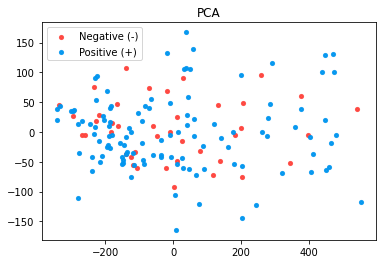

<Figure size 432x288 with 0 Axes>

In [12]:
# simplify high-dimensional data to find greatest variance
X = user_info
#X = X.drop(user_info.iloc[:, 9:27], axis = 1)
#X = X.drop(user_info.iloc[:, 0:9], axis = 1)

Y = X[X.columns[27:]].to_numpy().flatten().astype(int)
#print(Y)
X = X.drop("Parkinson's",axis=1)

pca = PCA(n_components=2) 
pca.fit(X)
print(pca.explained_variance_ratio_)

X_transformed = pca.transform(X)

colors = ['#FE433C','#0095EF']
lw = 2

class_names = ["Negative (-)", "Positive (+)"]
cn = np.array(class_names)

for color, i, class_names in zip(colors, list(range(0, 2)), class_names):
    plt.scatter(X_transformed[Y == i, 0], X_transformed[Y == i, 1], color=color, alpha=.9, lw=lw, s=10,
                label=class_names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.figure()
x_scaled = StandardScaler().fit_transform(X)

In [13]:
X.to_csv('data.csv')
!cp data.csv "drive/My Drive/SJSU"

**Linear SVC Model training**

In [14]:
X_final_train, X_final_test, Y_final_train, Y_final_test = train_test_split(x_scaled, Y, test_size=0.2, random_state=100)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
lr = linear_model.LogisticRegression()

accs = []
for train_index, test_index in skf.split(X_final_train, Y_final_train):
    x_train, x_test = X_final_train[train_index], X_final_train[test_index]
    y_train, y_test = Y_final_train[train_index], Y_final_train[test_index]

    model = LinearSVC(multi_class='ovr', class_weight='balanced').fit(x_train, y_train)
    accs.append(model.score(x_test, y_test))

print("Individual cross-validation accuracies: " + str(accs))
print("Mean cross-validation accuracy: {:.3f}".format(sum(accs) / len(accs)))

Individual cross-validation accuracies: [0.48, 0.56, 0.56, 0.6, 0.5833333333333334]
Mean cross-validation accuracy: 0.557


In [15]:
model.fit(X_final_train,Y_final_train)

print('Accuracy of linear SVC on test set: {:.2f}'.format(model.score(X_final_test, Y_final_test)))

Accuracy of linear SVC on test set: 0.61


**Linear SVC Results**

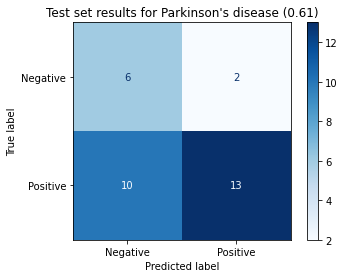

In [16]:
np.set_printoptions(precision=2)

for i in range(1):
  labels = []
  for j in range(len(Y)):
    if Y[j] == i:
      labels.append(1)
    else:
      labels.append(0)
  Y_digit = np.array(labels)
 # X_train, X_test, Y_train, Y_test = train_test_split(X, Y_digit, test_size=0.2, random_state=0, stratify=Y_digit)
  model.fit(X_final_train, Y_final_train)
  
  disp = plot_confusion_matrix(model, X_final_test, Y_final_test, display_labels=["Negative".format(i), "Positive".format(i)], cmap=plt.cm.Blues)
  disp.ax_.set_title("Test set results for Parkinson's disease ({score:.2f})".format(i, score=model.score(X_final_test, Y_final_test)))
  plt.show()

**Poly SVC Model training**

[0.59 0.24]


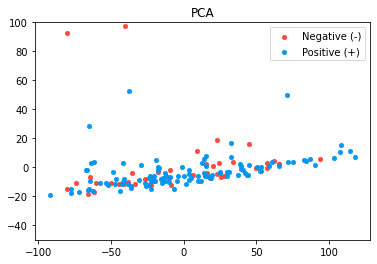

<Figure size 432x288 with 0 Axes>

In [17]:
# simplify high-dimensional data to find greatest variance
X = user_info
X = X.drop(user_info.iloc[:, 9:27], axis = 1)
#X = X.drop(user_info.iloc[:, 0:9], axis = 1)

Y = X[X.columns[9:]].to_numpy().flatten().astype(int)
#print(Y)
X = X.drop("Parkinson's",axis=1)

pca = PCA(n_components=2) 
pca.fit(X)
print(pca.explained_variance_ratio_)

X_transformed = pca.transform(X)

colors = ['#FE433C','#0095EF']
lw = 2

class_names = ["Negative (-)", "Positive (+)"]
cn = np.array(class_names)

for color, i, class_names in zip(colors, list(range(0, 2)), class_names):
    plt.scatter(X_transformed[Y == i, 0], X_transformed[Y == i, 1], color=color, alpha=.9, lw=lw, s=10,
                label=class_names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.ylim([-50, 100])
plt.figure()
#plt.xlim([-3, 3])
x_scaled = StandardScaler().fit_transform(X)

In [18]:
X_final_train, X_final_test, Y_final_train, Y_final_test = train_test_split(x_scaled, Y, test_size=0.2, random_state=100)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
lr = linear_model.LogisticRegression()

accs = []
for train_index, test_index in skf.split(X_final_train, Y_final_train):
    x_train, x_test = X_final_train[train_index], X_final_train[test_index]
    y_train, y_test = Y_final_train[train_index], Y_final_train[test_index]

    model = SVC(kernel='poly', class_weight='balanced').fit(x_train, y_train)
    accs.append(model.score(x_test, y_test))

print("Individual cross-validation accuracies: " + str(accs))
print("Mean cross-validation accuracy: {:.3f}".format(sum(accs) / len(accs)))

Individual cross-validation accuracies: [0.72, 0.76, 0.72, 0.52, 0.75]
Mean cross-validation accuracy: 0.694


In [19]:
model.fit(X_final_train,Y_final_train)

print('Accuracy of poly SVC on test set: {:.2f}'.format(model.score(X_final_test, Y_final_test)))

Accuracy of poly SVC on test set: 0.68


**Poly SVC Results**

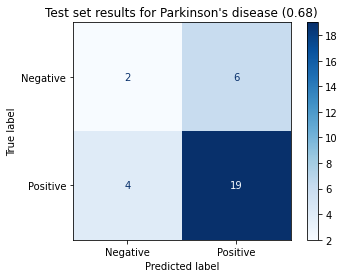

In [20]:
np.set_printoptions(precision=2)

for i in range(1):
  labels = []
  for j in range(len(Y)):
    if Y[j] == i:
      labels.append(1)
    else:
      labels.append(0)
  Y_digit = np.array(labels)
 # X_train, X_test, Y_train, Y_test = train_test_split(X, Y_digit, test_size=0.2, random_state=0, stratify=Y_digit)
  model.fit(X_final_train, Y_final_train)
  
  disp = plot_confusion_matrix(model, X_final_test, Y_final_test, display_labels=["Negative".format(i), "Positive".format(i)], cmap=plt.cm.Blues)
  disp.ax_.set_title("Test set results for Parkinson's disease ({score:.2f})".format(i, score=model.score(X_final_test, Y_final_test)))
  plt.show()